In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("cancer.csv")

## Pre-procesado de datos

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.shape

(569, 33)

In [5]:
df["Unnamed: 32"].unique()

array([nan])

In [6]:
X = df.iloc[:,2:-1] # Features del modelo
y = df["diagnosis"] # Diagnóstico

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Debido a que los datos se hayan en diferentes unidades, se realiza una normalización de cada uno de ellos.

In [8]:
scaler = StandardScaler()

In [9]:
Xnorm=scaler.fit_transform(X_train)

In [10]:
Xnorm.shape

(398, 30)

Hecho esto, se observa que la cantidad de features es grande y no todos podrían estar aportando varianza al modelo.
Se realiza entonces una reducción de dimensionalidad usando Principal Component Analysis (PCA) comprobando primero qué cantidad de features contendría la mayor cantidad de varianza explicada.

In [11]:
varianza = []
for i in range(1,11):
    pca = PCA(n_components=i)
    pca.fit(Xnorm)
    varianza.append(pca.explained_variance_ratio_.sum())

In [12]:
varianzadf = pd.DataFrame({"componentes":np.arange(1,11),"varianza":varianza})

In [13]:
varianzadf.tail()

,componentes,varianza
5,6,0.886890
6,7,0.909524
7,8,0.926351
8,9,0.939298
9,10,0.951392


<AxesSubplot:xlabel='componentes', ylabel='varianza'>

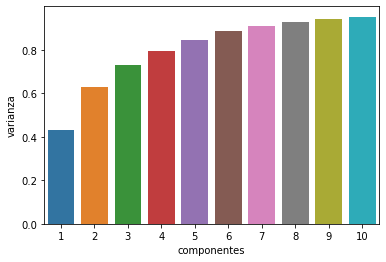

In [14]:
sns.barplot(x="componentes", y="varianza", data=varianzadf)

Se observa que con 10 componentes se obtiene la mázima varianza dentro del rango que se escogió probar. El PCA se lleva a cabo con este número.

In [15]:
pca = PCA(n_components=10)
pca.fit(Xnorm)

PCA(n_components=10)

In [16]:
pca.explained_variance_ratio_

array([0.4316748 , 0.19845652, 0.09733159, 0.06531574, 0.05212151,
       0.0419896 , 0.02263461, 0.01682669, 0.0129469 , 0.0120941 ])

In [17]:
Xpca=pca.transform(Xnorm)

In [18]:
Xpca.shape

(398, 10)

## Entrenamiento del modelo

El modelo ahora está listo para ser creado y entrenado con los datos normalizados y con dimensionalidad reducida.

In [19]:
clf = LogisticRegression(random_state=0)

In [20]:
clf.fit(Xpca,y_train)

LogisticRegression(random_state=0)

## Evaluación

In [21]:
Xnormtest = scaler.transform(X_test)

In [22]:
Xpcatest = pca.transform(Xnormtest)

In [23]:
Xpcatest.shape

(171, 10)

In [24]:
clf.score(Xpcatest,y_test)

0.9941520467836257

In [25]:
clf.predict(Xpcatest[:2,:])

array(['B', 'M'], dtype=object)

In [26]:
y_test[:2]

204    B
70     M
Name: diagnosis, dtype: object

In [27]:
X_test.shape

(171, 30)

In [28]:
y_pred = clf.predict(Xpcatest)

In [29]:
y_test.value_counts()

B    108
M     63
Name: diagnosis, dtype: int64

In [30]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[108,   0],
       [  1,  62]], dtype=int64)

In [31]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("confusion_matrix.png")

Confusion matrix, without normalization
[[108   0]
 [  1  62]]


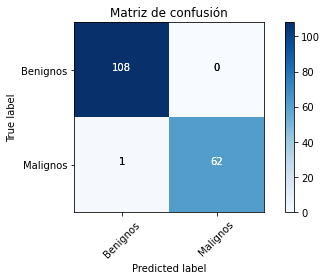

In [36]:
cm_plot_labels=["Benignos", "Malignos"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Matriz de confusión")

In [35]:
print(classification_report(y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           B       0.99      1.00      1.00       108
           M       1.00      0.98      0.99        63

    accuracy                           0.99       171
   macro avg       1.00      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

